In [1]:
%matplotlib notebook

import numpy as np
import cvxopt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles

# Kernels

Consider a training set $X\in M_{m \times n}(\mathbb{R})$ and target labels $y\in \mathbb{R}^n$, where $y \in \left\{+1, -1\right\}$. The kernel trick involves mapping feature vectors $x \in \mathbb{R}^n$ to a higher-dimensional feature space $\phi(x)$.
<br><br>
\begin{equation}
    x \mapsto \phi(x)
\end{equation}
<br><br>
We mainly focus on replacing inner products $\langle x,z \rangle$ in our equations in the soft margin SVM with $K(x,z)$
<br><br>
\begin{equation}
    K(x,z) = \phi(x)^T \phi(x)
\end{equation}
<br><br>
The most widely-used kernels are
<br><br>
\begin{align}
    K(x,z) &= x^T z \tag{Flat kernel}\\
    K(x,z) &= (x^T z + a)^d \tag{Polynomial kernel}\\
    K(x,z) &= \exp\left(-\frac{\Vert x - z\Vert^2}{2 \sigma^2}\right) \tag{Radial basis function kernel}\\
    K(x,z) &= \tanh(a x^Tz - b) \tag{Sigmoid kernel}
\end{align}
<br><br>
We note that since we are now working on higher-dimensional space $\phi(x)$ we must replace our equations for the weights $w$, bias $b$, and hypothesis function $h_{w,b}(\phi(x))$. We see that in the formula for the weights that it is impossible to calculate for the RBF kernel because $\phi(x)$ is infinite-dimensional:
<br><br>
\begin{align}
    w = \sum_{i=1}^m \alpha_i y^{(i)} \phi(x^{(i)})
\end{align}
<br>
So we must replace $\langle x,z \rangle \rightarrow K(x,z)$ in all of our expressions.
<br><br>
\begin{align}
    h_{w,b}(x) &= \text{sgn}(w^T z + b)\\
                 &= \text{sgn}\left[\left( \sum_{i \in S} \alpha_i y^{(i)} \phi(x^{(i)}) \right)^T \phi(x) + b\right]\\
     h_{w,b}(x) &= \text{sgn}\left[\sum_{i \in S} \alpha_i y^{(i)} K(x^{(i)}, x) + b\right] \tag{New expression for $h_{w,b}$}
\end{align}
<br><br>
We note that $S$ denotes the set of indices of the elements of the Lagrange multipliers that are $\alpha_i > 0$. Lastly, the bias term expression is updated to:
<br><br>
\begin{align}
    b &= \frac{1}{N_s} \sum_{i \in S} \left[y^{(i)} - w^T \phi(x_i)  \right] \\
        &= \frac{1}{N_s} \sum_{i \in S} \left[y^{(i)} - \left(\sum_{j \in S} \alpha_j y^{(j)} \phi(x_j)\right)^T \phi(x_i)  \right] \\
      b &= \frac{1}{N_s} \sum_{i \in S} \left[y^{(i)} - \sum_{j \in S} \alpha_j y^{(j)} K(x_i, x_j)  \right] \tag{New expression for $b$}
\end{align}
<br><br>

# SVM class

In [2]:
class SVM:
    def __init__(self, X, y, setKernel):
        self.X = X
        self.y = y
        self.setKernel = setKernel
    
    def fit(self, C=10e-2, tols=10e-5):
        assert C > 0, "C must be greater than 0."
        assert C > tols, "C must be greater than tols."
        assert len(self.X) > 0, "Must have at least 1 training example."
        assert len(self.X) == len(self.y), "Number of training examples and target labels not the same."
        assert (self.setKernel == 'flat') | (self.setKernel[0] == 'RBF') | (self.setKernel[0] == 'polynomial') | (self.setKernel[0] == 'sigmoid'), "Kernel options are flat, RBF, polynomial, and sigmoid."
    
        # Number of training examples m and the number of dimensions n
        m, n = self.X.shape
        
        # Convert y=0 into y=-1
        self.y[self.y==0] = -1

        # Assemble the matrices for the CVXOPT solver
        ## Quadratic part
        K = np.zeros((m, m)) # initialize the kernel matrix
        for i in range(m):
            for j in range(m):
                K[i, j] = self.__k(self.X[i,:], self.X[j,:], self.setKernel)

        P = cvxopt.matrix(np.outer(self.y, self.y) * K)

        ## Linear part
        q = cvxopt.matrix(-1 * np.ones(m))

        ## Inequality constraints
        G = cvxopt.matrix(np.concatenate((-1*np.eye(m), np.eye(m)), axis=0))
        h = cvxopt.matrix(np.concatenate((np.zeros(m), C*np.ones(m)), axis=0))

        ## Equality constraints
        A = cvxopt.matrix(1.0 * self.y, (1, m))
        b = cvxopt.matrix(0.0)

        # Solve the quadratic programming problem
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.α = np.ravel(solution['x']) # Lagrange multipliers

        # Find the indices with nonzero Lagrange multipliers
        self.S = np.where((self.α > tols) & (self.α <= C))[0]
        
        # Computes for the bias
        b = 0
        for s_i in self.S:
            b += self.y[s_i]
            for s_j in self.S:
                b += (- self.α[s_j]) * self.y[s_j] * self.__k(self.X[s_i], self.X[s_j], self.setKernel)

        self.b = 1/(len(self.S)) * b                
        
        
    def __k(self, x_i, x_j, setKernel):
        assert len(x_i)==len(x_j), "Input vectors must be of the same dimensions."

        if setKernel=='flat':
            return np.dot(x_i, x_j)

        elif setKernel[0]=='polynomial':
            a = setKernel[1]
            d = setKernel[2]
            return (np.dot(x_i, x_j) + a)**d

        elif setKernel[0] == 'RBF':
            σ = setKernel[1]
            return np.exp(- np.linalg.norm(x_i - x_j)**2 / (2 * σ**2))

        elif setKernel[0] =='sigmoid':
            a = setKernel[1]
            b = setKernel[2]
            return np.tanh(a*np.dot(x_i, x_j) - b)
   

    def predict(self, x_new):
        return np.array([self.__predict_individual(x_new_i) for x_new_i in x_new])
    
    
    def __predict_individual(self, x):
        y_hat = 0
        for X_S_i, α_S_i, y_S_i in zip(self.X[self.S], self.α[self.S], self.y[self.S]):
            y_hat += α_S_i*y_S_i * self.__k(X_S_i, x, self.setKernel)

        y_hat = np.sign(y_hat + self.b)

        if y_hat==0:
            y_hat = -1

        return y_hat

    
    def accuracy_score(self, y_test_true, y_test_pred):
        # Replaces the 0 labels for y with -1
        y_test_true[y_test_true == 0] = -1
        y_test_pred[y_test_pred == 0] = -1
        
        # Returns the accuracy score
        return np.sum(y_test_true == y_test_pred) / len(y_test_true)

# Polynomial kernel on moons data

In [7]:
X, y = make_moons(n_samples=100, noise=0.15, shuffle=True, random_state=42)
y[y==0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Model parameters

pol_deg = 3
const = 1
C = 5
tols=1e-2 

# SVM classifier
SVM_clf = SVM(X_train, y_train, ['polynomial', const, pol_deg])
SVM_clf.fit(C, tols)

### Make predictions

In [8]:
y_pred = SVM_clf.predict(X_test)
y_pred

array([ 1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1.,  1., -1., -1.])

### Accuracy score

In [9]:
acc_score = SVM_clf.accuracy_score(y_test, y_pred)
acc_score

0.95

### Plot the decision boundary

<IPython.core.display.Javascript object>


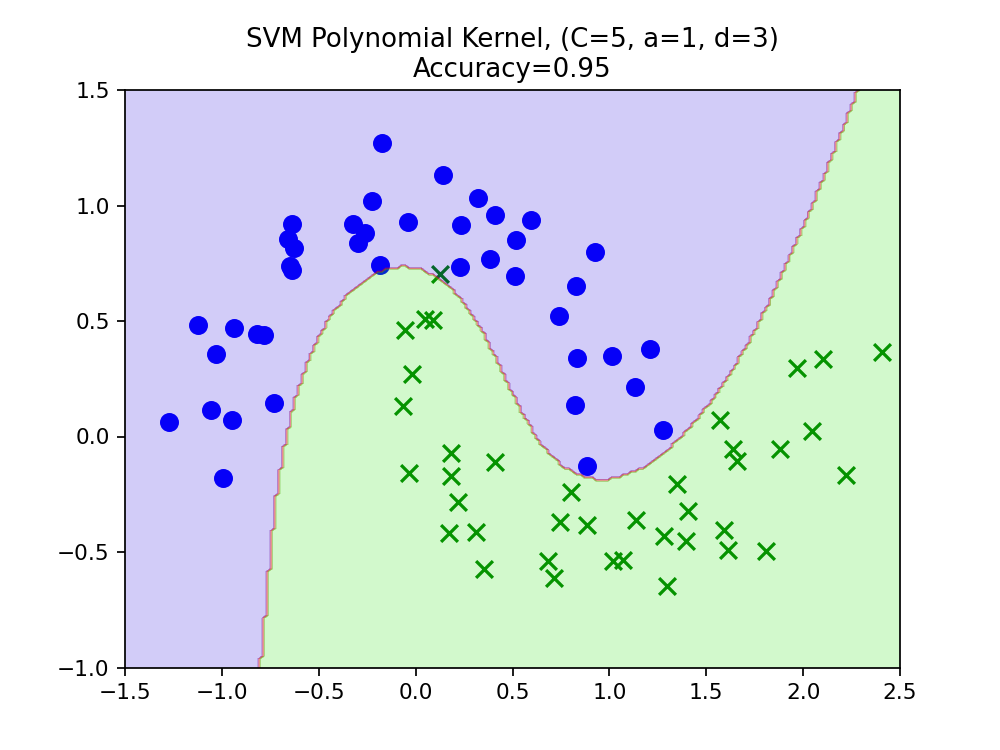

Text(0.5, 1.0, 'SVM Polynomial Kernel, (C=5, a=1, d=3)\nAccuracy=0.95')

In [10]:
plt.figure()
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c='green', marker='x', label="+1", s=60)
plt.scatter(X_train[y_train==-1][:,0], X_train[y_train==-1][:,1], c='blue', marker='o', label="-1", s=60)
axes = [-1.5, 2.5, -1, 1.5]
x0s = np.linspace(axes[0], axes[1], 200)
x1s = np.linspace(axes[2], axes[3], 200)
x0, x1 = np.meshgrid(x0s, x1s)
X_temp = np.c_[x0.ravel(), x1.ravel()]
y_pred_grid = SVM_clf.predict(X_temp).reshape(x0.shape)
plt.contourf(x0, x1, y_pred_grid, cmap=plt.cm.brg, alpha=0.2)
plt.title('SVM Polynomial Kernel, (C={}, a={}, d={})\nAccuracy={:.2f}'.format(C, const, pol_deg, acc_score))

# RBF Kernel

<IPython.core.display.Javascript object>


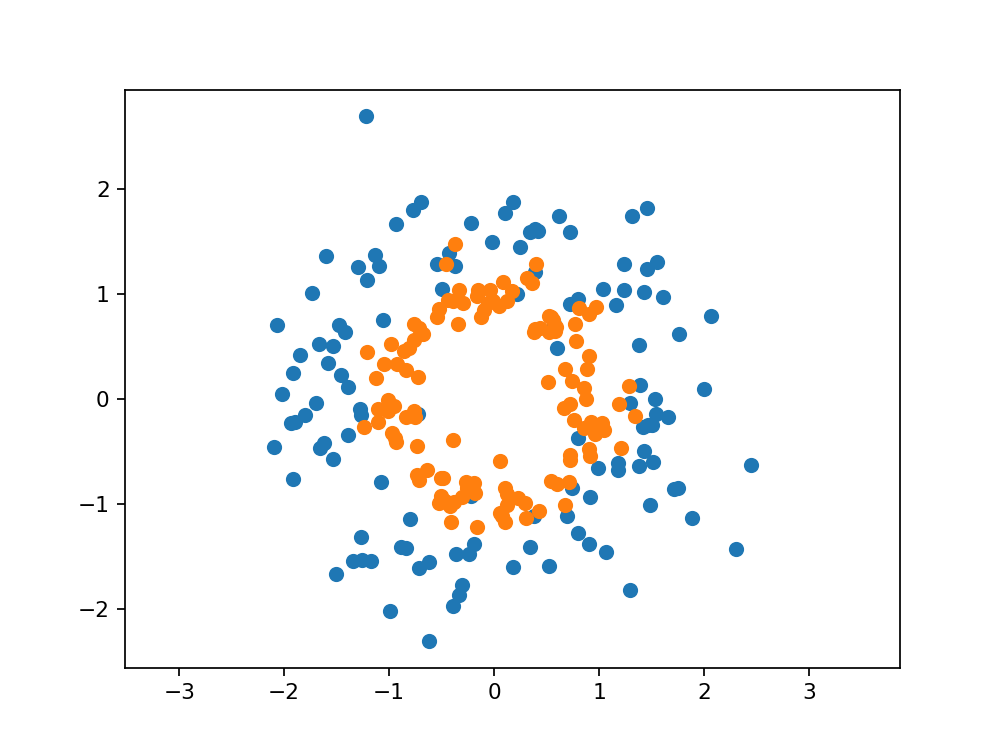

(-2.3200444445204123,
 2.672373366454261,
 -2.558308475290754,
 2.9439747988509515)

In [11]:
X, y = make_circles(n_samples=300, noise=.2, shuffle=True, random_state=4)
y[y==0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Add a bit to the X data to better separate the classes
X_train[y_train==1] *= 2
X_test[y_test==1] *= 2

plt.figure()
plt.scatter(X_train[np.where(y_train==1)][:,0], X_train[np.where(y_train==1)][:,1], label='y = 1')
plt.scatter(X_train[np.where(y_train==-1)][:,0], X_train[np.where(y_train==-1)][:,1], label='y = -1')
plt.axis('equal')

In [12]:
# RBF SVM classifier

σ = 1
C = 5
tols=1e-2

SVM_clf_RBF = SVM(X_train, y_train, ['RBF', σ])
SVM_clf_RBF.fit(C, tols)

### Make predictions

In [13]:
y_pred = SVM_clf_RBF.predict(X_test)
y_pred

array([ 1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1.,
       -1., -1., -1.,  1.,  1., -1.,  1.,  1.])

### Accuracy score

In [14]:
acc_score = SVM_clf_RBF.accuracy_score(y_test, y_pred)
acc_score

0.8666666666666667

### Plot the decision boundary

<IPython.core.display.Javascript object>


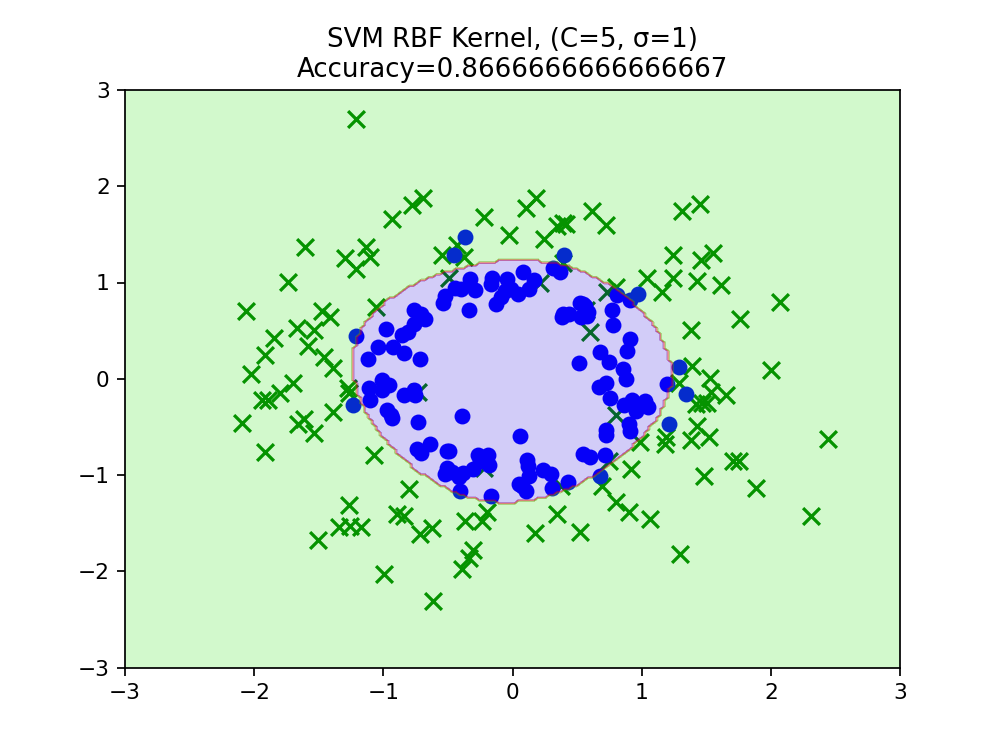

Text(0.5, 1.0, 'SVM RBF Kernel, (C=5, σ=1)\nAccuracy=0.8666666666666667')

In [15]:
plt.figure()
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c='green', marker='x', label="+1", s=60)
plt.scatter(X_train[y_train==-1][:,0], X_train[y_train==-1][:,1], c='blue', marker='o', label="-1", s=40)
axes = [-3, 3, -3, 3]
x0s = np.linspace(axes[0], axes[1], 200)
x1s = np.linspace(axes[2], axes[3], 200)
x0, x1 = np.meshgrid(x0s, x1s)
X_temp = np.c_[x0.ravel(), x1.ravel()]
y_pred_grid = SVM_clf_RBF.predict(X_temp).reshape(x0.shape)
plt.contourf(x0, x1, y_pred_grid, cmap=plt.cm.brg, alpha=0.2)
plt.title('SVM RBF Kernel, (C={}, σ={})\nAccuracy={}'.format(C, σ, acc_score))